In [ ]:
# !pip3 install konlpy

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import os
import pandas as pd
from pathlib import Path
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
from konlpy.tag import Okt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
source_files = sorted(Path('/content/drive/MyDrive/전주/jeonju_data_final/전주data/구글리뷰2/').glob('*.csv'))

dataframes = []
for file in source_files:
    df = pd.read_csv(file)
    df['filename'] = file.name.split('.')[0]
    dataframes.append(df)

google = pd.concat(dataframes)

In [ ]:
google.head()

,이름,날짜,댓글,filename
0,承고니,2달 전,NaN,강암서예관
1,Sewook Kim,6달 전,NaN,강암서예관
2,정동섭,9달 전,NaN,강암서예관
3,Jaesang Yoo,11달 전,글씨가 아름다움이 묻어나는 곳입니다.,강암서예관
4,이정우 (율운 이정우),1년 전,마음머무는곳,강암서예관


## **구글 - 외국인 리뷰**

In [ ]:
foreign = google['댓글'].str.contains('번역', na=  False)
not_kor = google[foreign]
not_kor

,이름,날짜,댓글,filename
12,Tony Pham,3년 전,2/12.53 would come again. Not much to see and ...,강암서예관
21,Lewis Mindy,4년 전,Free museum although don't expect any of the i...,강암서예관
5,고양이나만있어,1달 전,Here is the best road to drink coffee♡\n\n(Goo...,객리단길
24,Eric TW,5달 전,Came on Sunday so not too busy but like this a...,객리단길
291,Sachihiro Marcella,3년 전,Yummy\n\n(Google 번역 제공)\n아주 맛있는,객리단길
...,...,...,...,...
24,Andreia Carvalho,7달 전,"Just a gate, somehow welcoming.\n\n(Google 번역 ...",호남제일문
108,YASEEN ALGABRI,1년 전,Beautiful\n\n(Google 번역 제공)\n아름다운,호남제일문
144,Paul Kang,2년 전,Iconic gate. Good place to take advantage of t...,호남제일문
264,김미연,3년 전,(Google 번역 제공) 나쁘지 않다\n\n(원문)\n还不错,호남제일문


In [ ]:
def extract_word(text):
  import re
  hangul = re.compile('[^가-힣ㄱ-ㅎ]')
  result = hangul.sub(' ', text)
  return result

In [ ]:
not_kor['댓글'] =not_kor['댓글'].apply(lambda x:extract_word(x))

<ipython-input-6-7bd5110ae958>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_kor['댓글'] =not_kor['댓글'].apply(lambda x:extract_word(x))


In [ ]:
not_kor['댓글'] = not_kor['댓글'].str.replace(r'번역 제공', '', regex=True)

<ipython-input-7-c11eb79d529c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_kor['댓글'] = not_kor['댓글'].str.replace(r'번역 제공', '', regex=True)


In [ ]:
not_kor['댓글'] = not_kor['댓글'].str.replace(r'원문', '', regex=True)

<ipython-input-8-d00b662069b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_kor['댓글'] = not_kor['댓글'].str.replace(r'원문', '', regex=True)


In [ ]:
not_kor.head()

,이름,날짜,댓글,filename
12,Tony Pham,3년 전,...,강암서예관
21,Lewis Mindy,4년 전,...,강암서예관
5,고양이나만있어,1달 전,...,객리단길
24,Eric TW,5달 전,...,객리단길
291,Sachihiro Marcella,3년 전,아주 맛있는,객리단길


In [ ]:
not_kor = not_kor.groupby(['filename'])['댓글'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
not_kor.head()

,filename,댓글
0,강암서예관,...
1,객리단길,...
2,경기전,...
3,교동미술관,...
4,국립무형유산원,...


In [ ]:
path='/content/drive/MyDrive/전주/jeonju_data_final/전주data/'

with open(path+'전주_불용어.txt', 'r', encoding='utf-8') as f:
  stopwords=set(f.readlines())
  stopwords=list(map(lambda x:x.strip(), stopwords))

In [ ]:
stopwords.append('이다')
stopwords.append('방문')
stopwords.append('없음')
stopwords.append('아니요')

In [ ]:
stopwords[:10]

['일', '느낌', '시간 대기', '방문 주말', '주말', '매우', '시간 예약', '감사 ㅂ니다', '너무 아요', '평일 대기']

In [ ]:
# NLTK 사용을 위하여 선행 패키지를 설치한다.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
okt = Okt()

def tokenize(text):
  tokens=[]
  words=[]
  for t in okt.pos(text,stem=True):
    if t[1] in  ['Noun', 'Verb', 'Adjective'] and t[0] not in stopwords and len(t[0])>1:
      n='/'.join(t)
      tokens.append(n)
      words.append(t[0])


  #tokens = ['/'.join(t) for t in tagger.pos(text)]

  #return tokens
  return words

In [ ]:
n_gram = []
for review in tqdm(not_kor['댓글']):
    n_gram.append(' '.join(okt.morphs(review, stem=True)))

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


In [ ]:
len(n_gram)

50

In [ ]:
def tokenize(text):
  tokens=[]
  words=[]
  for t in okt.pos(text,stem=True):
    if t[1] in  ['Noun', 'Verb', 'Adjective'] and t[0] not in stopwords and len(t[0])>1:
      n='/'.join(t)
      tokens.append(n)
      words.append(t[0])
  return words

In [ ]:
tokens=[]
for i in range(len(n_gram)):
  a=tokenize(n_gram[i])
  tokens.append(a)
print(tokens)

[['다시', '오다', '많다', '않다', '모두', '한국어', '당신', '한국인', '라면', '흥미롭다', '당신', '한국어', '이해', '하다', '하다', '여기', '오지', '말다', '있다', '가보다', '않다', '늘다', '충분하다', '보다', '무료', '박물관', '영어', '되다', '정보', '늘다', '기대하다', '말다', '여기', '서예', '예술', '감탄', '하다', '감상', '하다', '있다'], ['여기', '가다', '커피', '말다', '없다', '일요일', '오다', '때문', '바쁘다', '않다', '지역', '좋아하다', '좋다', '음식점', '카페', '가다', '많다', '하다', '마을', '보다', '저렴하다', '한국', '음식', '휴식', '취하', '싶다', '서다', '양식', '옵션', '있다', '같다', '없다', '모르다', '맛있다', '최상'], ['고대', '조선', '왕조', '대해', '배우다', '좋다', '조선', '태조', '초상화', '하나', '오다', '왕실', '기록', '하다', '일부', '섹션', '소장', '하다', '있다', '모르다', '않다', '하다', '최대', '아니다', '오다', '아무', '없다', '확실하다', '없다', '아니다', '왕족', '모시', '있다', '이상', '인스타', '감성', '포트', '라든지', '하다', '있다', '같다', '한복', '입다', '커플', '집단', '곳곳', '촬영', '하다', '있다', '보다', '놀라다', '모르다', '평화', '좋다', '조선왕조', '이성계', '고향', '없다', '괜찮다', '기대하다', '있다', '만큼', '유익하다', '않다', '건물', '대해', '서다', '가다', '얼마', '인지', '궁금하다', '들다', '거의', '읽다', '없다', '안내', '판이', '있다', '그것', '당신', '기대하다', '있다', '최소한', '이

In [ ]:
def trigram_extract(word_list):
  word_list = [v for v in word_list if v]
  if len(word_list)>1:
    result = list(zip(word_list, word_list[1:], word_list[2:]))
  else:
    result = []
  return result

In [1]:
def bigram_extract(word_list):
  word_list = [v for v in word_list if v]
  if len(word_list)>1:
    result = list(zip(word_list, word_list[1:]))
  else:
    result = []
  return result

In [ ]:
trigram=[]
for i in tokens:
  trigram.append(trigram_extract(i))
  #trigram.append(ngrams(i, 3, pad_left=True, pad_right=True, left_pad_symbol="", right_pad_symbol=""))


In [ ]:
print(trigram)

[[('다시', '오다', '많다'), ('오다', '많다', '않다'), ('많다', '않다', '모두'), ('않다', '모두', '한국어'), ('모두', '한국어', '당신'), ('한국어', '당신', '한국인'), ('당신', '한국인', '라면'), ('한국인', '라면', '흥미롭다'), ('라면', '흥미롭다', '당신'), ('흥미롭다', '당신', '한국어'), ('당신', '한국어', '이해'), ('한국어', '이해', '하다'), ('이해', '하다', '하다'), ('하다', '하다', '여기'), ('하다', '여기', '오지'), ('여기', '오지', '말다'), ('오지', '말다', '있다'), ('말다', '있다', '가보다'), ('있다', '가보다', '않다'), ('가보다', '않다', '늘다'), ('않다', '늘다', '충분하다'), ('늘다', '충분하다', '보다'), ('충분하다', '보다', '무료'), ('보다', '무료', '박물관'), ('무료', '박물관', '영어'), ('박물관', '영어', '되다'), ('영어', '되다', '정보'), ('되다', '정보', '늘다'), ('정보', '늘다', '기대하다'), ('늘다', '기대하다', '말다'), ('기대하다', '말다', '여기'), ('말다', '여기', '서예'), ('여기', '서예', '예술'), ('서예', '예술', '감탄'), ('예술', '감탄', '하다'), ('감탄', '하다', '감상'), ('하다', '감상', '하다'), ('감상', '하다', '있다')], [('여기', '가다', '커피'), ('가다', '커피', '말다'), ('커피', '말다', '없다'), ('말다', '없다', '일요일'), ('없다', '일요일', '오다'), ('일요일', '오다', '때문'), ('오다', '때문', '바쁘다'), ('때문', '바쁘다', '않다'), ('바쁘다', '않다', '지역'), ('않다', '지역', '좋아하

In [ ]:
bigram=[]
for i in tokens:
  bigram.append(bigram_extract(i))

In [ ]:
print(bigram)

[[('다시', '오다'), ('오다', '많다'), ('많다', '않다'), ('않다', '모두'), ('모두', '한국어'), ('한국어', '당신'), ('당신', '한국인'), ('한국인', '라면'), ('라면', '흥미롭다'), ('흥미롭다', '당신'), ('당신', '한국어'), ('한국어', '이해'), ('이해', '하다'), ('하다', '하다'), ('하다', '여기'), ('여기', '오지'), ('오지', '말다'), ('말다', '있다'), ('있다', '가보다'), ('가보다', '않다'), ('않다', '늘다'), ('늘다', '충분하다'), ('충분하다', '보다'), ('보다', '무료'), ('무료', '박물관'), ('박물관', '영어'), ('영어', '되다'), ('되다', '정보'), ('정보', '늘다'), ('늘다', '기대하다'), ('기대하다', '말다'), ('말다', '여기'), ('여기', '서예'), ('서예', '예술'), ('예술', '감탄'), ('감탄', '하다'), ('하다', '감상'), ('감상', '하다'), ('하다', '있다')], [('여기', '가다'), ('가다', '커피'), ('커피', '말다'), ('말다', '없다'), ('없다', '일요일'), ('일요일', '오다'), ('오다', '때문'), ('때문', '바쁘다'), ('바쁘다', '않다'), ('않다', '지역'), ('지역', '좋아하다'), ('좋아하다', '좋다'), ('좋다', '음식점'), ('음식점', '카페'), ('카페', '가다'), ('가다', '많다'), ('많다', '하다'), ('하다', '마을'), ('마을', '보다'), ('보다', '저렴하다'), ('저렴하다', '한국'), ('한국', '음식'), ('음식', '휴식'), ('휴식', '취하'), ('취하', '싶다'), ('싶다', '서다'), ('서다', '양식'), ('양식', '옵션'), ('옵션', '있다'), ('있다', '

In [ ]:
tri_list=[]
for i in trigram:
  for a,b,c in i:
    tri=  str(a)+'_'+str(b)+'_'+str(c)
    tri_list.append(tri)
tri_list

In [ ]:
len(tri_list)

14420

In [ ]:
bi_list=[]
for i in bigram:
  for a,b, in i:
    bi=  str(a)+'_'+str(b)
    bi_list.append(bi)
bi_list

In [ ]:
# tri_list  = set(tri_list)

In [ ]:
tri_list

In [ ]:
from collections import Counter
counter=Counter(tri_list)
most_occur=counter.most_common(50)
print(most_occur)

[('가치_가다_있다', 35), ('하다_가치_가다', 24), ('긍정_가격_대비', 21), ('가격_대비_만족도', 21), ('있다_없다_아니다', 19), ('산책_하다_좋다', 19), ('대비_만족도_신속하다', 17), ('만족도_신속하다_응답', 17), ('신속하다_응답_전문성', 15), ('응답_전문성_품질', 15), ('적극_추천_하다', 10), ('좋다_없다_아니다', 9), ('추천_하다_없다', 9), ('벽화_가다_있다', 9), ('없다_아니다_아름답다', 8), ('하다_하다_마을', 8), ('하다_하다_가치', 7), ('휴식_취하_좋다', 7), ('있다_하다_마을', 7), ('하다_긍정_가격', 7), ('감상_하다_있다', 6), ('대여_하다_있다', 6), ('하다_좋다_없다', 6), ('체험_하다_있다', 6), ('하다_좋다_좋다', 6), ('아이_들다_하다', 6), ('강력하다_추천_하다', 6), ('작가_늘다_전문', 6), ('한복_대여_하다', 6), ('자다_관리_되어다', 5), ('하다_없다_아니다', 5), ('한복_입다_찍기', 5), ('영어_구사_하다', 5), ('하다_있다_좋다', 5), ('않다_없다_아니다', 5), ('없다_아니다_하다', 5), ('없다_아니다_늘다', 5), ('포즈_취하_늘다', 5), ('작가_늘다_친절하다', 5), ('경험_하다_있다', 5), ('하다_있다_멋지다', 5), ('전문성_품질_늘다', 5), ('가다_있다_없다', 5), ('분위기_가다_좋다', 5), ('왕실_초상화_박물관', 4), ('하다_추천_하다', 4), ('자다_관리_되다', 4), ('있다_하다_좋다', 4), ('가다_있다_멋지다', 4), ('탐험_하다_좋다', 4)]


In [ ]:
from collections import Counter
counter=Counter(bi_list)
most_occur_bi=counter.most_common(30)
print(most_occur_bi)

[('없다_아니다', 100), ('하다_있다', 96), ('하다_마을', 91), ('가다_있다', 88), ('하다_좋다', 79), ('추천_하다', 60), ('하다_하다', 54), ('가치_가다', 40), ('있다_좋다', 37), ('아이_들다', 33), ('한복_입다', 32), ('하다_늘다', 31), ('산책_하다', 31), ('촬영_하다', 30), ('있다_멋지다', 27), ('하다_없다', 26), ('하다_않다', 24), ('하다_가치', 24), ('있다_하다', 24), ('작가_늘다', 24), ('가보다_하다', 22), ('있다_없다', 22), ('한국_전통', 22), ('가격_대비', 22), ('긍정_가격', 21), ('대비_만족도', 21), ('되어다_있다', 20), ('전문성_품질', 20), ('경험_하다', 19), ('하다_아름답다', 18)]


In [ ]:
most_occur=[('가치_가다_있다', 35), ('긍정_가격_대비', 21), ('가격_대비_만족도', 21), ('산책_하다_좋다', 19),
 ('만족도_신속하다_응답', 17), ('응답_전문성_품질', 15), ('적극_추천_하다', 10),('벽화_가다_있다', 9), ('휴식_취하_좋다', 7),
   ('감상_하다_있다', 6), ('대여_하다_있다', 6),('체험_하다_있다', 6), ('아이_들다_하다', 6), ('강력하다_추천_하다', 6), ('작가_늘다_전문', 6),
   ('한복_대여_하다', 6),('한복_입다_찍기', 5), ('영어_구사_하다', 5),('분위기_가다_좋다', 5), ('왕실_초상화_박물관', 4)]


In [ ]:
len(most_occur)

20

In [ ]:
x, y= [], []
for word,count in most_occur:
    x.append(word)
    y.append(count)

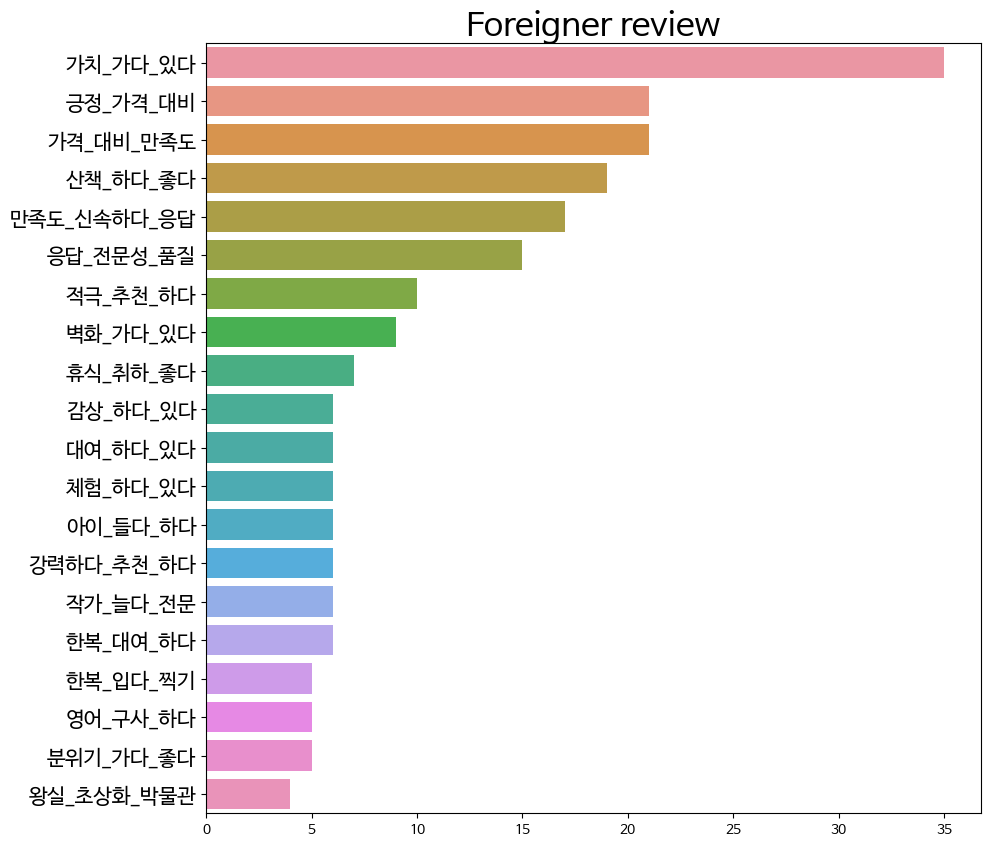

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
# plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=y,y=x)
plt.title('Foreigner review')
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

## **구글 - 한국인 리뷰**

In [ ]:
kor = google[~foreign]
kor.head()

,이름,날짜,댓글,filename
0,承고니,2달 전,NaN,강암서예관
1,Sewook Kim,6달 전,NaN,강암서예관
2,정동섭,9달 전,NaN,강암서예관
3,Jaesang Yoo,11달 전,글씨가 아름다움이 묻어나는 곳입니다.,강암서예관
4,이정우 (율운 이정우),1년 전,마음머무는곳,강암서예관


In [ ]:
kor['댓글'] =kor['댓글'].apply(lambda x:extract_word(str(x)))

In [ ]:
kor['댓글'] =kor['댓글'].apply(lambda x:extract_word(x))

In [ ]:
kor

,이름,날짜,댓글,filename
0,承고니,2달 전,,강암서예관
1,Sewook Kim,6달 전,,강암서예관
2,정동섭,9달 전,,강암서예관
3,Jaesang Yoo,11달 전,글씨가 아름다움이 묻어나는 곳입니다,강암서예관
4,이정우 (율운 이정우),1년 전,마음머무는곳,강암서예관
...,...,...,...,...
530,윤바다,6년 전,전주 고속버스 터미널에서 출발한 고속버스가 잠시 정차하여 승하차 하는 곳 주변에 ...,호남제일문
531,정글찬,6년 전,,호남제일문
532,류원영,6년 전,ㅎㅎ,호남제일문
533,대박이야,6년 전,고속버스정차장이 있습니다,호남제일문


In [ ]:
n_gram_k = []
for review in tqdm(kor['댓글']):
    n_gram_k.append(' '.join(okt.morphs(review, stem=True)))

100%|██████████| 27181/27181 [00:55<00:00, 486.18it/s]


In [ ]:
len(n_gram_k)

27181

In [ ]:
tokens=[]
for i in range(len(n_gram_k)):
  a=tokenize(n_gram_k[i])
  tokens.append(a)
print(tokens)

[[], [], [], ['글씨', '가다', '아름답다', '묻다'], ['마음', '머물다'], ['대나무', '그림', '들다', '한자', '늘다', '자다', '모르다', '서체', '늘다', '자다', '모르다'], ['하다', '마을', '찾다', '많다', '들다', '찾기', '바라다', '호남', '일문', '쓰다', '신분', '이십'], ['멋있다'], [], ['들다', '하다'], [], ['하다', '마을', '지다', '직원', '담당', '하다', '시설'], [], [], [], [], ['하다', '마을', '용하다', '화장실', '사용', '하다', '편하다', '안내', '친절', '이렇다', '없다', '에어컨', '하다', '부담', '이용', '하다'], [], [], ['나다', '초등학교', '동네', '서다', '대회', '최우수상', '타다'], ['남녀', '공용', '화장실'], ['화장실'], ['친절하다', '글귀', '들다'], [], ['하다', '마을', '회관', '공짜', '즐기다', '있다', '한자', '여행'], ['좋다', '한버', '오다'], ['작품', '들다', '보지', '하다', '지금', '해보다', '왜안', '들어가다', '싶다', '외관', '멋있다', '기억'], [], ['좋다'], ['강암', '송성용', '선생님', '작품', '전시', '되어다', '있다', '하다', '마을', '하다', '들다', '들다', '관람', '하다', '보시', '권하다', '싶다'], [], [], ['중세시대', '고전', '주의', '예술가', '문자', '추상화'], [], [], [], ['없다', '아니다'], ['없다', '아니다'], ['없다', '모르다'], [], ['많다'], ['객리', '달다', '다가', '양조장', '오후', '오픈', '넘어서다', '가다', '저희', '자리', '잡다', '부터', '웨이', '신분증', '무조건', '있다', '없

In [ ]:
trigram2=[]
for i in tokens:
  trigram2.append(trigram_extract(i))
  #trigram.append(ngrams(i, 3, pad_left=True, pad_right=True, left_pad_symbol="", right_pad_symbol=""))


In [ ]:
print(trigram2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tri_list2=[]
for i in trigram2:
  for a,b,c in i:
    tri=  str(a)+'_'+str(b)+'_'+str(c)
    tri_list2.append(tri)
tri_list2

['글씨_가다_아름답다',
 '가다_아름답다_묻다',
 '대나무_그림_들다',
 '그림_들다_한자',
 '들다_한자_늘다',
 '한자_늘다_자다',
 '늘다_자다_모르다',
 '자다_모르다_서체',
 '모르다_서체_늘다',
 '서체_늘다_자다',
 '늘다_자다_모르다',
 '하다_마을_찾다',
 '마을_찾다_많다',
 '찾다_많다_들다',
 '많다_들다_찾기',
 '들다_찾기_바라다',
 '찾기_바라다_호남',
 '바라다_호남_일문',
 '호남_일문_쓰다',
 '일문_쓰다_신분',
 '쓰다_신분_이십',
 '하다_마을_지다',
 '마을_지다_직원',
 '지다_직원_담당',
 '직원_담당_하다',
 '담당_하다_시설',
 '하다_마을_용하다',
 '마을_용하다_화장실',
 '용하다_화장실_사용',
 '화장실_사용_하다',
 '사용_하다_편하다',
 '하다_편하다_안내',
 '편하다_안내_친절',
 '안내_친절_이렇다',
 '친절_이렇다_없다',
 '이렇다_없다_에어컨',
 '없다_에어컨_하다',
 '에어컨_하다_부담',
 '하다_부담_이용',
 '부담_이용_하다',
 '나다_초등학교_동네',
 '초등학교_동네_서다',
 '동네_서다_대회',
 '서다_대회_최우수상',
 '대회_최우수상_타다',
 '남녀_공용_화장실',
 '친절하다_글귀_들다',
 '하다_마을_회관',
 '마을_회관_공짜',
 '회관_공짜_즐기다',
 '공짜_즐기다_있다',
 '즐기다_있다_한자',
 '있다_한자_여행',
 '좋다_한버_오다',
 '작품_들다_보지',
 '들다_보지_하다',
 '보지_하다_지금',
 '하다_지금_해보다',
 '지금_해보다_왜안',
 '해보다_왜안_들어가다',
 '왜안_들어가다_싶다',
 '들어가다_싶다_외관',
 '싶다_외관_멋있다',
 '외관_멋있다_기억',
 '강암_송성용_선생님',
 '송성용_선생님_작품',
 '선생님_작품_전시',
 '작품_전시_되어다',
 '전시_되어다_있다',
 '되어다_있다_하다',
 '있다_하다_마을',
 '하다_마을_하다',
 '마을

In [ ]:
len(tri_list2)

92590

In [ ]:
from collections import Counter
counter=Counter(tri_list)
most_occur=counter.most_common(80)
print(most_occur)

[('산책_하다_좋다', 355), ('좋다_없다_아니다', 96), ('공휴일_없다_아니다', 91), ('긍정_가격_대비', 54), ('가격_대비_만족도', 54), ('자다_되어다_있다', 52), ('구경_하다_좋다', 51), ('아이_들다_좋아하다', 51), ('관리_가다_자다', 46), ('신속하다_응답_전문성', 46), ('응답_전문성_품질', 46), ('체험_하다_있다', 44), ('볼거리_가다_많다', 43), ('대비_만족도_신속하다', 41), ('만족도_신속하다_응답', 41), ('가다_자다_되어다', 40), ('좋다_추억_만들다', 38), ('하다_마을_있다', 35), ('들다_놀다_좋다', 34), ('있다_아이_들다', 34), ('하다_있다_좋다', 32), ('하다_없다_아니다', 32), ('아이_들다_하다', 32), ('하다_하다_마을', 32), ('운동_하다_좋다', 31), ('아이_들다_놀다', 30), ('좋다_추억_남다', 30), ('있다_없다_아니다', 29), ('하다_마을_하다', 28), ('재미_가다_있다', 28), ('좋다_하다_마을', 28), ('즐겁다_촬영_하다', 28), ('거리_가다_많다', 27), ('하다_마을_오다', 26), ('경치_가다_좋다', 26), ('좋다_아이_들다', 26), ('하다_마을_가깝다', 26), ('아이_들다_데리', 26), ('있다_하다_마을', 25), ('규모_가다_크다', 25), ('나들이_하다_좋다', 25), ('하다_좋다_없다', 24), ('하다_좋다_같다', 24), ('객실_서비스_위치', 23), ('한복_입다_찍다', 22), ('어리다_아이_들다', 21), ('들다_산책_하다', 21), ('하다_마을_가다', 21), ('아이_들다_좋다', 20), ('하다_마을_위치', 20), ('들다_가기_좋다', 20), ('동물_들다_있다', 20), ('조용하다_산책_하다', 19), ('하다_마을_보다', 19

In [ ]:
from collections import Counter
counter=Counter(tri_list2)
most_occur2=counter.most_common(80)
print(most_occur2)

[('산책_하다_좋다', 355), ('좋다_없다_아니다', 96), ('공휴일_없다_아니다', 91), ('긍정_가격_대비', 54), ('가격_대비_만족도', 54), ('자다_되어다_있다', 52), ('구경_하다_좋다', 51), ('아이_들다_좋아하다', 51), ('관리_가다_자다', 46), ('신속하다_응답_전문성', 46), ('응답_전문성_품질', 46), ('체험_하다_있다', 44), ('볼거리_가다_많다', 43), ('대비_만족도_신속하다', 41), ('만족도_신속하다_응답', 41), ('가다_자다_되어다', 40), ('좋다_추억_만들다', 38), ('하다_마을_있다', 35), ('들다_놀다_좋다', 34), ('있다_아이_들다', 34), ('하다_있다_좋다', 32), ('하다_없다_아니다', 32), ('아이_들다_하다', 32), ('하다_하다_마을', 32), ('운동_하다_좋다', 31), ('아이_들다_놀다', 30), ('좋다_추억_남다', 30), ('있다_없다_아니다', 29), ('하다_마을_하다', 28), ('재미_가다_있다', 28), ('좋다_하다_마을', 28), ('즐겁다_촬영_하다', 28), ('거리_가다_많다', 27), ('하다_마을_오다', 26), ('경치_가다_좋다', 26), ('좋다_아이_들다', 26), ('하다_마을_가깝다', 26), ('아이_들다_데리', 26), ('있다_하다_마을', 25), ('규모_가다_크다', 25), ('나들이_하다_좋다', 25), ('하다_좋다_없다', 24), ('하다_좋다_같다', 24), ('객실_서비스_위치', 23), ('한복_입다_찍다', 22), ('어리다_아이_들다', 21), ('들다_산책_하다', 21), ('하다_마을_가다', 21), ('아이_들다_좋다', 20), ('하다_마을_위치', 20), ('들다_가기_좋다', 20), ('동물_들다_있다', 20), ('조용하다_산책_하다', 19), ('하다_마을_보다', 19

In [ ]:
most_occur = [('산책_하다_좋다', 355), ('긍정_가격_대비', 54), ('가격_대비_만족도', 54), ('구경_하다_좋다', 51), ('아이_들다_좋아하다', 51),
  ('신속하다_응답_전문성', 46), ('응답_전문성_품질', 46), ('체험_하다_있다', 44), ('볼거리_가다_많다', 43),
   ('좋다_추억_만들다', 38),  ('운동_하다_좋다', 31),  ('좋다_추억_남다', 30),
     ('재미_가다_있다', 28), ('즐겁다_촬영_하다', 28), ('거리_가다_많다', 27), ('경치_가다_좋다', 26),
              ('하다_마을_가깝다', 26),  ('규모_가다_크다', 25), ('나들이_하다_좋다', 25),
                ('한복_입다_찍다', 22)]


In [ ]:
len(most_occur)

20

In [ ]:
x, y= [], []
for word,count in most_occur:
    x.append(word)
    y.append(count)

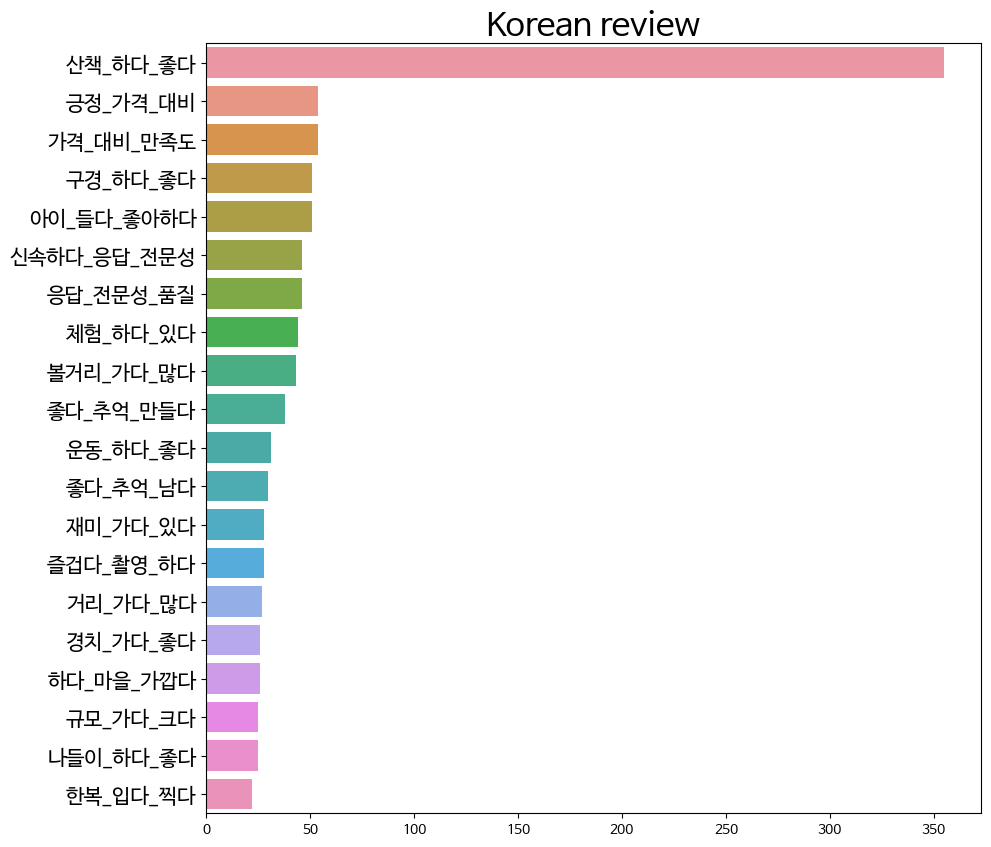

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
# plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=y,y=x)
plt.title('Korean review')
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기